In [3]:
%load_ext IPython.extensions.autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../..')
from model import FinData
from model import merged_split
from model import CatboostFinModel
from model import train_valid_test_split
from model import test_average_return
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

c:\Users\Валерия\OneDrive\Документы\GitHub\prices-predictions\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Посмотрим среднюю волатильность разных акций по часам + построим графики для разных компаний типо барплотов средняя волатильность по часам за год-полгода + комиссия 

In [3]:
data = FinData("../../datasets/Sber_10_min.csv")

Посмотрим, как с этим заданием справится мой первый помощник 

In [5]:
data.restrict_time_down(datetime(2024, 1, 1))
data.restrict_time_up(datetime(2024, 12, 31))
df = data.df

In [14]:
def vis_volatility(comm_value, df):
    # Значение комиссии
    comission = comm_value * 2  # в процентах

    # Преобразуем utc в datetime и добавим столбец часов
    df['utc'] = pd.to_datetime(df['utc'])
    df['hour'] = df['utc'].dt.hour

    # Рассчитываем процентную разницу между close_t и close_{t+1}
    df['close_shifted'] = df['close'].shift(-1)
    # тут процентная волатильность от среднего 
    df['volatility'] = (df['close_shifted'] - df['close']).abs() / ((df['close_shifted'] + df['close']) / 2) * 100

    # Группируем по часам и считаем среднюю волатильность
    hourly_volatility = df.groupby('hour')['volatility'].mean()

    # Визуализация
    plt.figure(figsize=(12, 6))
    plt.bar(hourly_volatility.index, hourly_volatility, color='blue', alpha=0.7, label='Средняя волатильность')
    plt.axhline(y=comission, color='red', linestyle='--', label=f'Комиссия ({comission}%)')
    plt.xlabel('Часы')
    plt.ylabel('Средняя волатильность (%)')
    plt.title('Средняя волатильность по часам')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_hourly_volatility(dfs, comm_value, labels=None):
    """
    Рассчитывает среднюю волатильность по часам и строит график для нескольких датафреймов.
    
    :param dfs: список датафреймов
    :param commission: уровень комиссии (float), который будет отображаться на графике
    :param labels: список меток для каждого датафрейма (по умолчанию None)
    """

    commission = comm_value * 2
     

    plt.figure(figsize=(12, 6))
    
    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(len(dfs))]
    
    for df, label in zip(dfs, labels):
        df['hour'] = pd.to_datetime(df['utc']).dt.hour
        # Рассчитываем процентную разницу между close_t и close_{t+1}
        df['close_shifted'] = df['close'].shift(-1)
        # тут процентная волатильность от среднего 
        df['volatility'] = (df['close_shifted'] - df['close']).abs() / ((df['close_shifted'] + df['close']) / 2) * 100
        hourly_volatility = df.groupby('hour')['volatility'].mean()
        sns.barplot(x=hourly_volatility.index, y=hourly_volatility.values, label=label)
    
    plt.axhline(y=commission, color='red', linestyle='--', label='Commission Level')
    plt.xlabel("Hour of the day")
    plt.ylabel("Average Volatility")
    plt.title("Hourly Volatility Across Multiple Datasets")
    plt.legend()
    plt.grid()
    plt.show()

# Пример вызова функции
# dfs = [df1, df2, df3, df4, df5]  # список датафреймов
# calculate_hourly_volatility(dfs, commission=0.002, labels=["Dataset 1", "Dataset 2", "Dataset 3", "Dataset 4", "Dataset 5"])


In [3]:
down_time = datetime(2023, 1, 1)
up_time = datetime(2023, 12, 31)


data_Sber = FinData("../../datasets/Sber_10_min.csv")
data_Sber.restrict_time_down(down_time)
data_Sber.restrict_time_up(up_time)
df_Sber = data_Sber.df


data_Yn = FinData("../../datasets/Yandex_10_min.csv")
data_Yn.restrict_time_down(down_time)
data_Yn.restrict_time_up(up_time)
df_Yn = data_Yn.df


data_VTB = FinData("../../datasets/VTB_10_min.csv")
data_VTB.restrict_time_down(down_time)
data_VTB.restrict_time_up(up_time)
df_VTB = data_VTB.df


data_Tatneft = FinData("../../datasets/Tatneft_10_min.csv")
data_Tatneft.restrict_time_down(down_time)
data_Tatneft.restrict_time_up(up_time)
df_Tatneft = data_Tatneft.df

data_Gazprom = FinData("../../datasets/Gazprom_10_min.csv")
data_Gazprom.restrict_time_down(down_time)
data_Gazprom.restrict_time_up(up_time)
df_Gazprom = data_Gazprom.df


dfs = [df_Sber, df_Yn, df_VTB, df_Tatneft, df_Gazprom]
labels = ["Sber", "Yandex", "VTB", "Tatneft", "Gazprom"]

In [6]:
data = FinData(df_Yn)

windows_shifts_norms = [2, 3, 4, 5, 6]
windows_ma = [2, 4, 6, 8, 18, 30, 50]
windows_ema = [3, 5, 7, 9, 20, 35, 100]

data.insert_shifts_norms(windows_shifts_norms=windows_shifts_norms)
data.insert_rolling_means(windows_ma=windows_ma)
data.insert_exp_rolling_means(windows_ema=windows_ema)
data.insert_bollinger()
data.insert_rsi()
data.insert_high_low_diff()
data.insert_stochastic_oscillator()
data.insert_random_prediction()

cat = data.get_cat_features()
num = data.get_numeric_features()



In [11]:
def filter_by_hours(df, hours_to_remove):
    """
    Удаляет свечи с определенными часами из датасета.
    
    :param df: DataFrame с колонкой 'utc' в формате datetime.
    :param hours_to_remove: Список часов (int), которые нужно удалить.
    :return: Отфильтрованный DataFrame.
    """
    return df[~df['utc'].dt.hour.isin(hours_to_remove)]

In [12]:
remove_hours = [1, 2, 3, 4, 5, 6, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23, 0]

df = filter_by_hours(data.df, hours_to_remove=remove_hours)

cat = data.get_cat_features()
num = data.get_numeric_features()

In [13]:
args = {"iterations" : 3000, 
        "depth" : 5, 
        "learning_rate" : 0.01, 
        "use_best_model" : True, 
        "l2_leaf_reg" : 3,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Logloss', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 500}

In [14]:
model = CatboostFinModel(args) 

In [15]:
model.test_trading(data.df, cat=cat, num=num, start_date=datetime(2023, 1, 1), end_date=datetime(2023, 12, 31), proportion=(3, 1, 1), commision=0.0004, short=False)

2025-02-18 18:47:08,569 - INFO - Backtesting started
2025-02-18 18:47:08,575 - INFO - Train dates: 2023-01-01 09:00:00 - 2023-08-09 12:30:00 | Valid dates: 2023-08-09 12:40:00 - 2023-10-19 19:40:00 | Test dates: 2023-10-19 19:50:00 - 2023-12-30 15:50:00


0:	learn: 0.6925798	test: 0.6925809	best: 0.6925809 (0)	total: 50.8ms	remaining: 2m 32s
1:	learn: 0.6920920	test: 0.6920836	best: 0.6920836 (1)	total: 121ms	remaining: 3m 1s
2:	learn: 0.6915532	test: 0.6915357	best: 0.6915357 (2)	total: 159ms	remaining: 2m 38s
3:	learn: 0.6910362	test: 0.6910188	best: 0.6910188 (3)	total: 236ms	remaining: 2m 56s
4:	learn: 0.6904903	test: 0.6904729	best: 0.6904729 (4)	total: 300ms	remaining: 2m 59s
5:	learn: 0.6900158	test: 0.6900035	best: 0.6900035 (5)	total: 394ms	remaining: 3m 16s
6:	learn: 0.6895292	test: 0.6895475	best: 0.6895475 (6)	total: 433ms	remaining: 3m 5s
7:	learn: 0.6890318	test: 0.6890967	best: 0.6890967 (7)	total: 499ms	remaining: 3m 6s
8:	learn: 0.6885919	test: 0.6886756	best: 0.6886756 (8)	total: 525ms	remaining: 2m 54s
9:	learn: 0.6880818	test: 0.6881829	best: 0.6881829 (9)	total: 633ms	remaining: 3m 9s
10:	learn: 0.6876919	test: 0.6878202	best: 0.6878202 (10)	total: 657ms	remaining: 2m 58s
11:	learn: 0.6872179	test: 0.6873473	best: 0

2025-02-18 18:49:30,545 - INFO - LONG! - Date&Time: 2023-10-19 19:50:00 - I bought Yandex for 2656.6 and sold for 2659.0 + commission 6.37872 -> budget: 10000.82128
2025-02-18 18:49:30,563 - INFO - LONG! - Date&Time: 2023-10-19 20:10:00 - I bought Yandex for 2657.0 and sold for 2656.4 + commission 6.37608 -> budget: 9992.6452
2025-02-18 18:49:30,589 - INFO - LONG! - Date&Time: 2023-10-19 20:20:00 - I bought Yandex for 2656.4 and sold for 2657.0 + commission 6.37608 -> budget: 9988.06912


1703:	learn: 0.6097509	test: 0.6595163	best: 0.6590608 (1207)	total: 2m 16s	remaining: 1m 44s
1704:	learn: 0.6097135	test: 0.6595245	best: 0.6590608 (1207)	total: 2m 16s	remaining: 1m 43s
1705:	learn: 0.6096803	test: 0.6595321	best: 0.6590608 (1207)	total: 2m 16s	remaining: 1m 43s
1706:	learn: 0.6096487	test: 0.6595688	best: 0.6590608 (1207)	total: 2m 16s	remaining: 1m 43s
1707:	learn: 0.6096055	test: 0.6595679	best: 0.6590608 (1207)	total: 2m 16s	remaining: 1m 43s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6590608257
bestIteration = 1207

Shrink model to first 1208 iterations.


2025-02-18 18:49:30,612 - INFO - LONG! - Date&Time: 2023-10-20 07:00:00 - I bought Yandex for 2677.4 and sold for 2677.6 + commission 6.426 -> budget: 9982.24312
2025-02-18 18:49:30,617 - INFO - LONG! - Date&Time: 2023-10-20 07:10:00 - I bought Yandex for 2677.6 and sold for 2692.8 + commission 6.4444799999999995 -> budget: 10021.39864
2025-02-18 18:49:30,651 - INFO - LONG! - Date&Time: 2023-10-20 07:30:00 - I bought Yandex for 2677.0 and sold for 2657.0 + commission 6.4008 -> budget: 9954.99784
2025-02-18 18:49:30,658 - INFO - LONG! - Date&Time: 2023-10-20 07:40:00 - I bought Yandex for 2657.0 and sold for 2663.2 + commission 6.38424 -> budget: 9967.2136
2025-02-18 18:49:30,675 - INFO - LONG! - Date&Time: 2023-10-20 08:00:00 - I bought Yandex for 2653.6 and sold for 2656.8 + commission 6.3724799999999995 -> budget: 9970.44112
2025-02-18 18:49:30,711 - INFO - LONG! - Date&Time: 2023-10-20 08:30:00 - I bought Yandex for 2667.0 and sold for 2668.2 + commission 6.40224 -> budget: 9967.638

(12.600080000067464, 0.5866163996229972)

In [13]:
data = FinData(Yn_data_filtered)

windows_shifts_norms = [2, 3, 4, 5, 6]
windows_ma = [2, 4, 6, 8, 18, 30, 50]
windows_ema = [3, 5, 7, 9, 20, 35, 100]

data.insert_shifts_norms(windows_shifts_norms=windows_shifts_norms)
data.insert_rolling_means(windows_ma=windows_ma)
data.insert_exp_rolling_means(windows_ema=windows_ema)
data.insert_bollinger()
data.insert_rsi()
data.insert_high_low_diff()
data.insert_stochastic_oscillator()
data.insert_random_prediction()

KeyError: 0

In [16]:
df_Yn

,utc,open,close,high,low,volume,direction_binary
0,2023-01-01 09:00:00,1813.6,1826.2,1826.2,1813.0,134,1
1,2023-01-01 09:10:00,1826.2,1827.4,1827.4,1815.6,46,0
2,2023-01-01 09:20:00,1827.4,1817.6,1828.4,1816.6,49,1
3,2023-01-01 09:30:00,1828.6,1831.0,1831.0,1815.8,330,1
4,2023-01-01 09:40:00,1819.8,1831.6,1831.6,1819.8,62,0
...,...,...,...,...,...,...,...
26517,2023-12-30 15:10:00,2539.0,2539.4,2539.6,2536.0,338,0
26518,2023-12-30 15:20:00,2536.0,2539.0,2539.4,2536.0,252,0
26519,2023-12-30 15:30:00,2539.0,2536.2,2539.0,2536.2,226,1
26520,2023-12-30 15:40:00,2536.2,2538.4,2539.4,2535.8,312,1


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_daily_volatility(dfs, comm_value, labels=None):
    """
    Рассчитывает среднюю волатильность по часам и строит 4 отдельных графика (2x2).
    
    :param dfs: список из 4 датафреймов
    :param comm_value: уровень комиссии (float), который будет отображаться на графике
    :param labels: список меток для каждого датафрейма (по умолчанию None)
    """
    if len(dfs) != 4:
        raise ValueError("Функция ожидает ровно 4 датафрейма.")
    
    commission = comm_value * 2
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
    axes = axes.flatten()
    
    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(4)]
    
    for i, (df, label) in enumerate(zip(dfs, labels)):
        df['hour'] = pd.to_datetime(df['utc']).dt.hour
        df['close_shifted'] = df['close'].shift(-1)
        df['volatility'] = (df['close_shifted'] - df['close']).abs() / ((df['close_shifted'] + df['close']) / 2) * 100
        df["day"] = pd.to_datetime(df['utc']).dt.day
        volatility = df.groupby('day')['volatility'].mean()
        
        sns.barplot(x=volatility.index, y=volatility.values, ax=axes[i])
        axes[i].axhline(y=commission, color='red', linestyle='--', label='Commission Level')
        axes[i].set_xlabel("Hour of the day")
        axes[i].set_ylabel("Average Volatility")
        axes[i].set_title(label)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

In [18]:
dfs = [df_Sber, df_Yn, df_VTB, df_Tatneft]
labels = ["Sber", "Yandex", "VTB", "Tatneft"]

2025-02-18 18:51:29,698 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-18 18:51:29,721 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-18 18:51:29,961 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-18 18:51:30,003 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-18 18:51:30,303 - INFO - Using categorical units to plot a list of strings that are all parsable as 

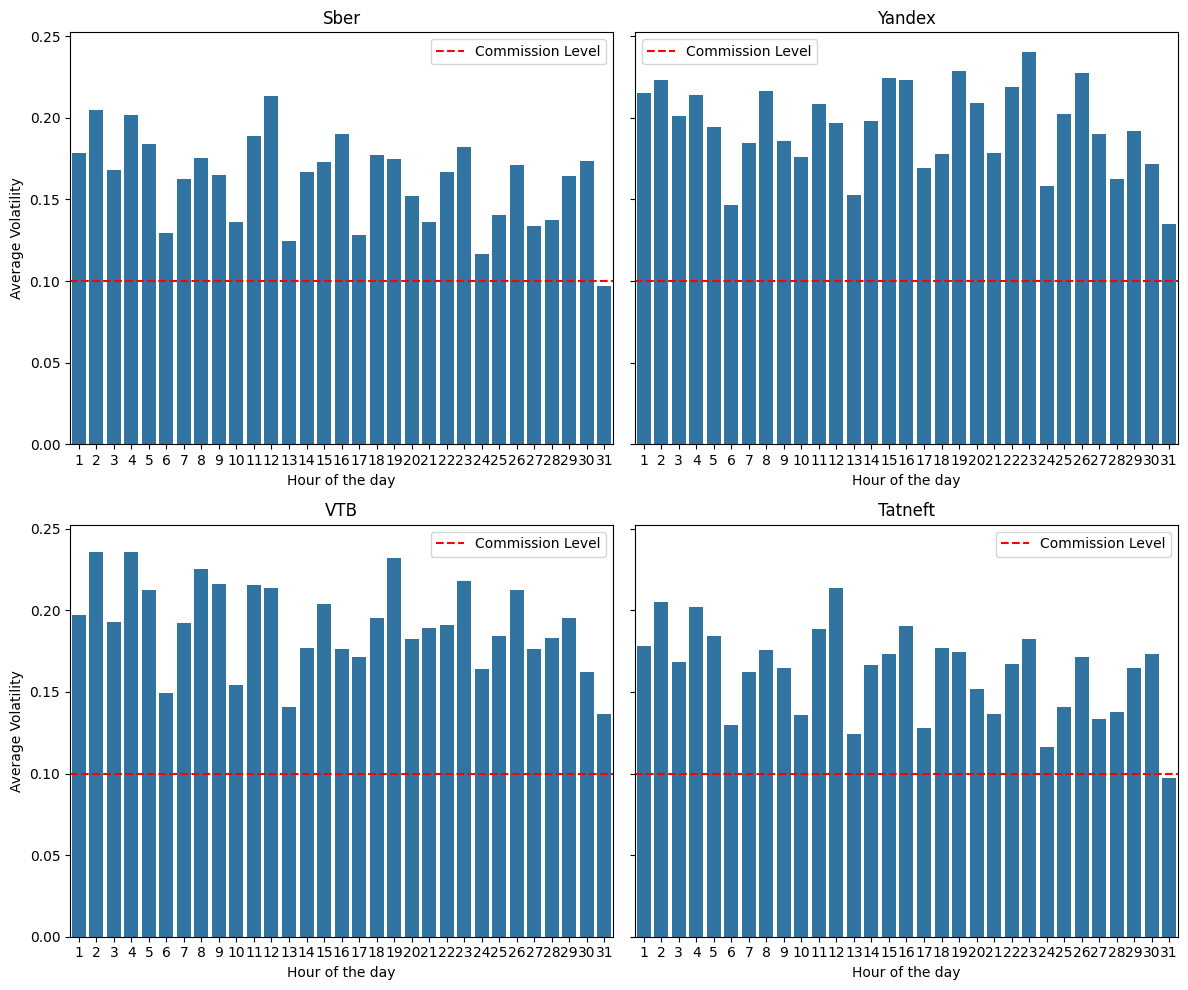

In [19]:
calculate_daily_volatility(dfs, comm_value=0.05, labels = labels)

Средняя десятиминутная волатильность по дням

In [ ]:
names = ["Sber", "MTS", "Yandex", "MMK", "Gazprom", "Whoosh"]


In [66]:
down_time = datetime(2024, 10, 23)
up_time = datetime(2024, 11, 10)


data_Sber = FinData("../../datasets/Sber_1_min.csv")
data_Sber.restrict_time_down(down_time)
data_Sber.restrict_time_up(up_time)
df_Sber = data_Sber.df


data_MTS = FinData("../../datasets/MTS_1_min.csv")
data_MTS.restrict_time_down(down_time)
data_MTS.restrict_time_up(up_time)
df_MTS = data_MTS.df


data_Yandex = FinData("../../datasets/Yandex_1_min.csv")
data_Yandex.restrict_time_down(down_time)
data_Yandex.restrict_time_up(up_time)
df_Yandex = data_Yandex.df


data_MMK = FinData("../../datasets/MMK_1_min.csv")
data_MMK.restrict_time_down(down_time)
data_MMK.restrict_time_up(up_time)
df_MMK = data_MMK.df

data_Gazprom = FinData("../../datasets/Gazprom_1_min.csv")
data_Gazprom.restrict_time_down(down_time)
data_Gazprom.restrict_time_up(up_time)
df_Gazprom = data_Gazprom.df

data_Whoosh = FinData("../../datasets/Whoosh_1_min.csv")
data_Whoosh.restrict_time_down(down_time)
data_Whoosh.restrict_time_up(up_time)
df_Whoosh = data_Gazprom.df


dfs = [df_Sber, df_MTS, df_Yandex, df_MMK, df_Gazprom, df_Whoosh]
labels = ["Sber", "MTS", "Yandex", "MMK", "Gazprom", "Whoosh"]

In [43]:
df_Sber

,utc,open,close,high,low,volume,direction_binary


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_hourly_volatility(dfs, comm_value, labels=None):
    """
    Рассчитывает среднюю волатильность по часам и строит 6 отдельных графиков (3x2).
    
    :param dfs: список из 6 датафреймов
    :param comm_value: уровень комиссии (float), который будет отображаться на графике
    :param labels: список меток для каждого датафрейма (по умолчанию None)
    """
    if len(dfs) != 6:
        raise ValueError("Функция ожидает ровно 6 датафреймов.")
    
    commission = comm_value * 2
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
    axes = axes.flatten()
    
    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(6)]
    
    for i, (df, label) in enumerate(zip(dfs, labels)):
        df['hour'] = (pd.to_datetime(df['utc']).dt.hour + 3) % 24  # Добавляем 3 часа и корректируем по 24-часовому формату
        df = df[(df['hour'] >= 7) & (df['hour'] <= 23)]  # Оставляем только часы с 7 до 23
        df['close_shifted'] = df['close'].shift(-1)
        df['volatility'] = (df['close_shifted'] - df['close']).abs() / (df['close']) * 100
        # df['volatility'] = (df['close_shifted'] - df['close']).abs() / ((df['close'] + df['close_shifted'])/2) * 100
        volatility = df.groupby('hour')['volatility'].mean()
        
        sns.barplot(x=volatility.index, y=volatility.values, ax=axes[i])
        axes[i].axhline(y=commission, color='red', linestyle='--', label='Commission Level')
        axes[i].set_xlabel("Hour of the day")
        axes[i].set_ylabel("Average Volatility")
        axes[i].set_title(label)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()


In [58]:
def calculate_hourly_volume(dfs, labels=None):
    """
    Рассчитывает средний объем торгов по часам и строит 6 отдельных графиков (3x2).
    
    :param dfs: список из 6 датафреймов
    :param labels: список меток для каждого датафрейма (по умолчанию None)
    """
    if len(dfs) != 6:
        raise ValueError("Функция ожидает ровно 6 датафреймов.")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
    axes = axes.flatten()
    
    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(6)]
    
    for i, (df, label) in enumerate(zip(dfs, labels)):
        df['hour'] = (pd.to_datetime(df['utc']).dt.hour + 3) % 24  # Добавляем 3 часа и корректируем по 24-часовому формату
        df = df[(df['hour'] >= 7) & (df['hour'] <= 23)]  # Оставляем только часы с 7 до 23
        hourly_volume = df.groupby('hour')['volume'].mean()
        
        sns.barplot(x=hourly_volume.index, y=hourly_volume.values, ax=axes[i])
        axes[i].set_xlabel("Hour of the day")
        axes[i].set_ylabel("Average Trading Volume")
        axes[i].set_title(label)
    
    plt.tight_layout()
    plt.show()

2025-02-26 19:23:42,236 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-26 19:23:42,325 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-26 19:23:42,596 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-26 19:23:42,720 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-26 19:23:42,988 - INFO - Using categorical units to plot a list of strings that are all parsable as 

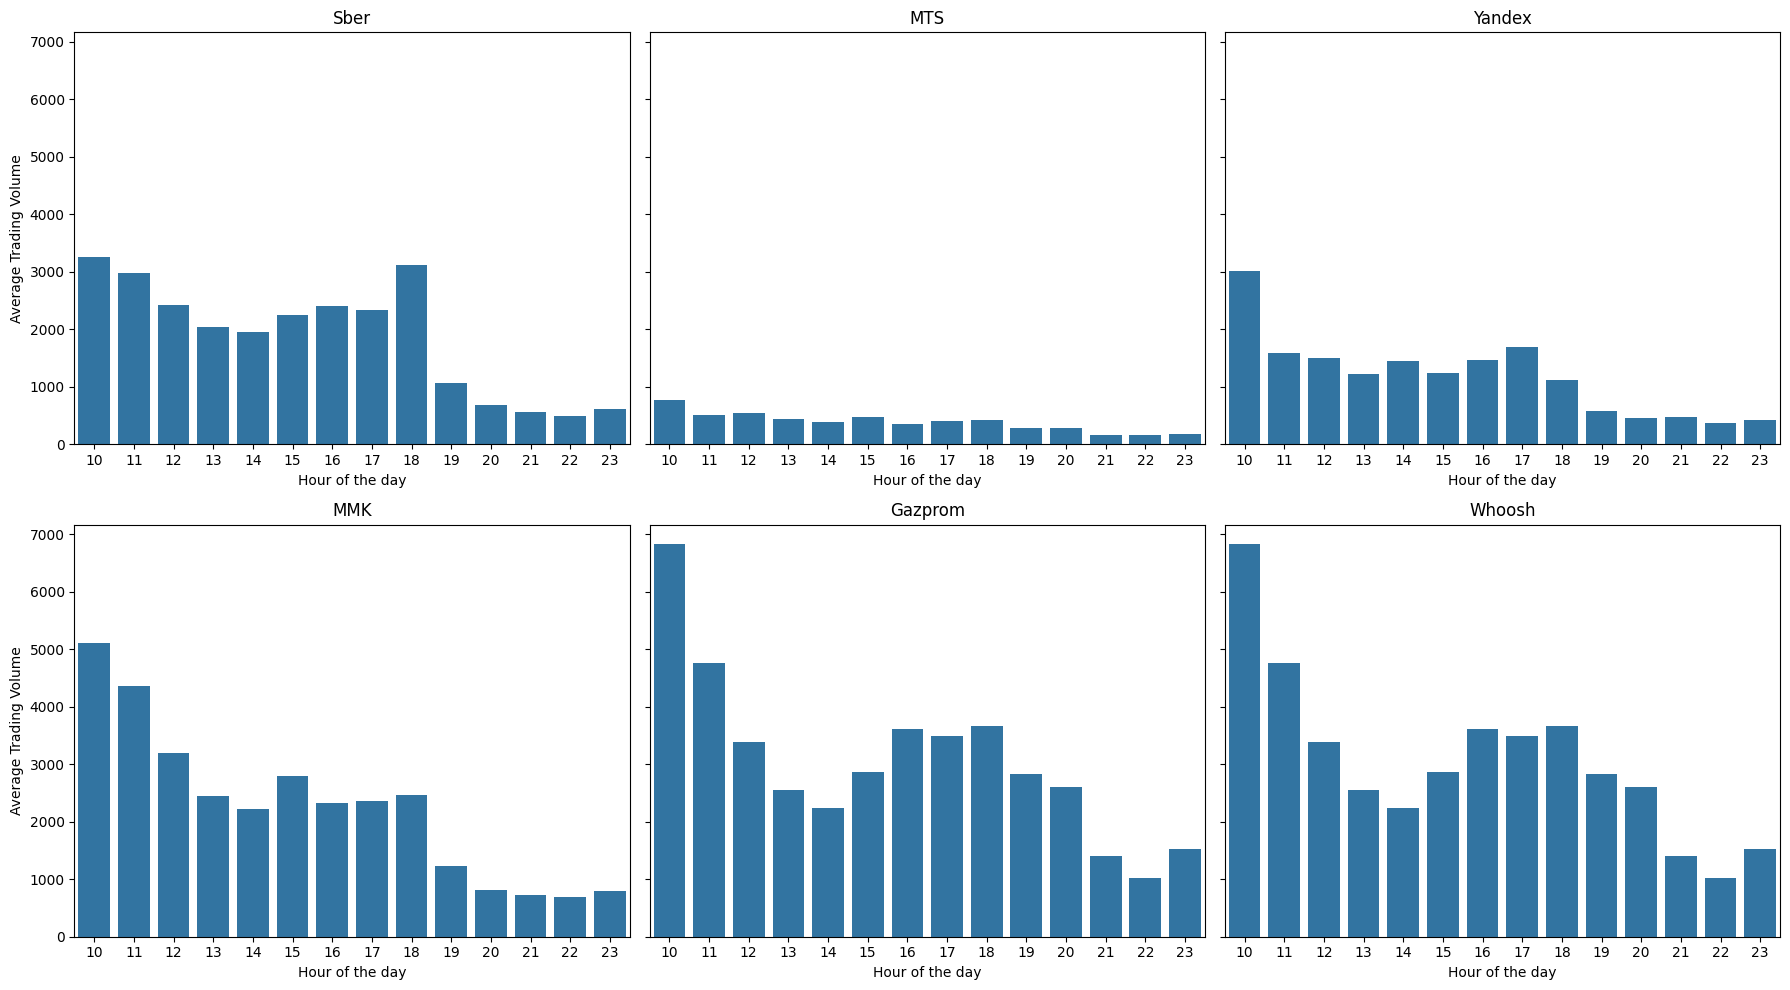

In [63]:
calculate_hourly_volume(dfs, labels = labels)

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_hourly_volatility(dfs, comm_value, labels=None):
    """
    Рассчитывает среднюю волатильность по часам и строит 6 отдельных графиков (3x2).
    
    :param dfs: список из 6 датафреймов
    :param comm_value: уровень комиссии (float), который будет отображаться на графике
    :param labels: список меток для каждого датафрейма (по умолчанию None)
    """
    if len(dfs) != 6:
        raise ValueError("Функция ожидает ровно 6 датафреймов.")
    
    commission = comm_value * 2
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
    axes = axes.flatten()
    
    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(6)]
    
    for i, (df, label) in enumerate(zip(dfs, labels)):
        df['hour'] = (pd.to_datetime(df['utc']).dt.hour + 3) % 24  # Добавляем 3 часа и корректируем по 24-часовому формату
        df['close_shifted'] = df['close'].shift(-1)
        df['volatility'] = (df['close_shifted'] - df['close']).abs() / (df['close']) * 100
        # df['volatility'] = (df['close_shifted'] - df['close']).abs() / ((df['close'] + df['close_shifted'])/2) * 100
        volatility = df.groupby('hour')['volatility'].mean()
        
        sns.barplot(x=volatility.index, y=volatility.values, ax=axes[i])
        axes[i].axhline(y=commission, color='red', linestyle='--', label='Commission Level')
        axes[i].set_xlabel("Hour of the day")
        axes[i].set_ylabel("Average Volatility")
        axes[i].set_title(label)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()


2025-02-26 19:26:00,925 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-26 19:26:00,956 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-26 19:26:01,248 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-26 19:26:01,269 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-26 19:26:01,423 - INFO - Using categorical units to plot a list of strings that are all parsable as 

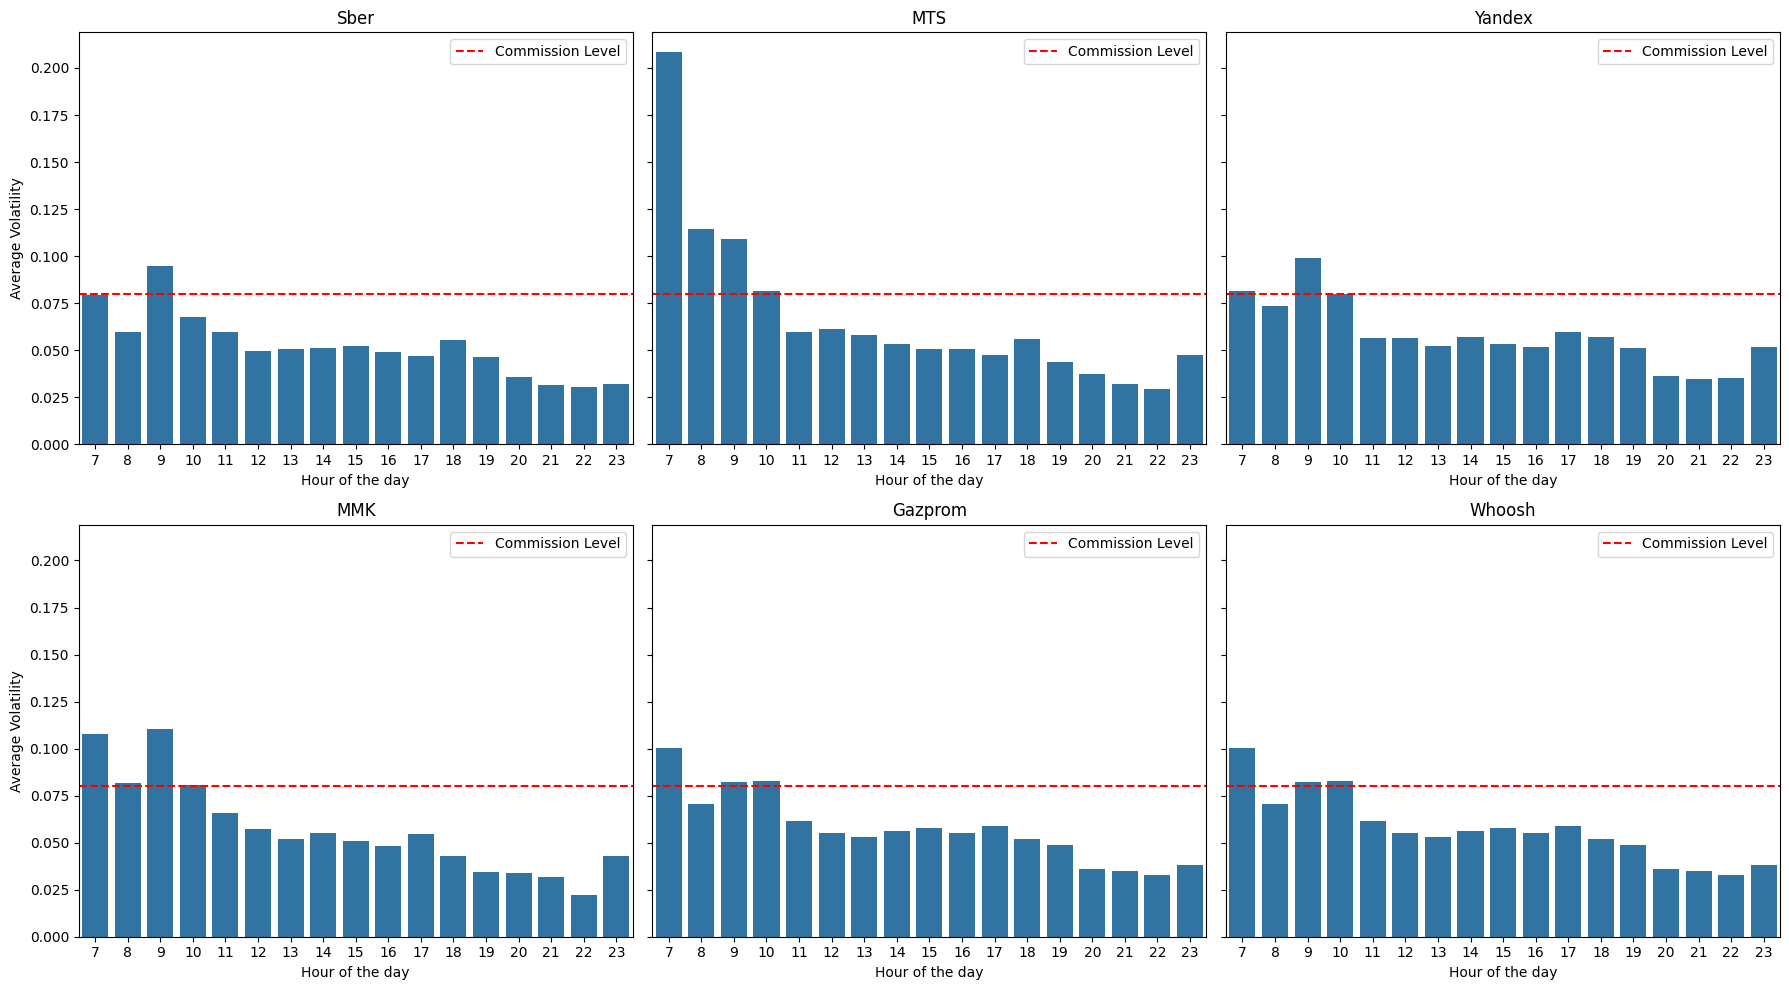

In [67]:
calculate_hourly_volatility(dfs, comm_value=0.04, labels = labels)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_hourly_volatility(dfs, comm_value, labels=None):
    """
    Рассчитывает среднюю волатильность по часам и строит 4 отдельных графика (2x2).
    
    :param dfs: список из 4 датафреймов
    :param comm_value: уровень комиссии (float), который будет отображаться на графике
    :param labels: список меток для каждого датафрейма (по умолчанию None)
    """
    if len(dfs) != 4:
        raise ValueError("Функция ожидает ровно 4 датафрейма.")
    
    commission = comm_value * 2
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
    axes = axes.flatten()
    
    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(4)]
    
    for i, (df, label) in enumerate(zip(dfs, labels)):
        df['hour'] = pd.to_datetime(df['utc']).dt.hour
        df['close_shifted'] = df['close'].shift(-1)
        df['volatility'] = (df['close_shifted'] - df['close']).abs() / (df['close']) * 100
        # df['volatility'] = (df['close_shifted'] - df['close']).abs() / ((df['close'] + df['close_shifted'])/2) * 100
        volatility = df.groupby('hour')['volatility'].mean()
        
        sns.barplot(x=volatility.index, y=volatility.values, ax=axes[i])
        axes[i].axhline(y=commission, color='red', linestyle='--', label='Commission Level')
        axes[i].set_xlabel("Hour of the day")
        axes[i].set_ylabel("Average Volatility")
        axes[i].set_title(label)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

2025-02-25 17:14:48,061 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-25 17:14:48,079 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-25 17:14:48,210 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-25 17:14:48,215 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-25 17:14:48,272 - INFO - Using categorical units to plot a list of strings that are all parsable as 

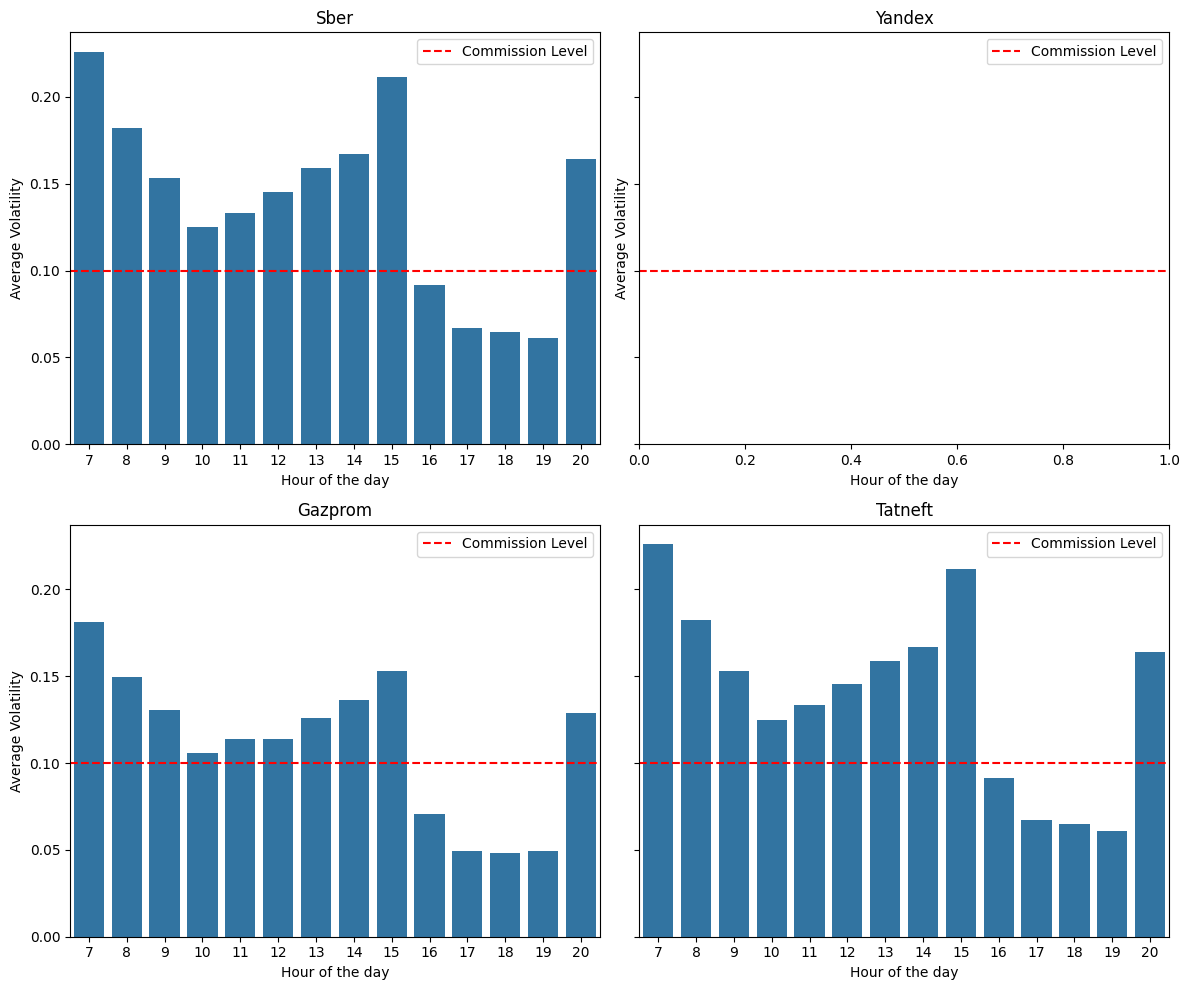

In [34]:
dfs = [df_Sber, df_Yn, df_Gazprom, df_Tatneft]
labels = ["Sber", "Yandex", "Gazprom", "Tatneft"]

calculate_hourly_volatility(dfs, comm_value=0.05, labels = labels)


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_hourly_volume(dfs, labels=None):
    """
    Рассчитывает средний объем торгов по часам и строит 4 отдельных графика (2x2).
    
    :param dfs: список из 4 датафреймов
    :param labels: список меток для каждого датафрейма (по умолчанию None)
    """
    if len(dfs) != 4:
        raise ValueError("Функция ожидает ровно 4 датафрейма.")
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
    axes = axes.flatten()
    
    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(4)]
    
    for i, (df, label) in enumerate(zip(dfs, labels)):
        df['hour'] = pd.to_datetime(df['utc']).dt.hour
        hourly_volume = df.groupby('hour')['volume'].mean()
        
        sns.barplot(x=hourly_volume.index, y=hourly_volume.values, ax=axes[i])
        axes[i].set_xlabel("Hour of the day")
        axes[i].set_ylabel("Average Trading Volume")
        axes[i].set_title(label)
    
    plt.tight_layout()
    plt.show()


In [48]:
dfs = [df_Sber, df_Yn, df_Gazprom, df_Tatneft]
labels = ["Sber", "Yandex", "Gazprom", "Tatneft"]

2025-02-12 12:12:26,304 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-12 12:12:26,310 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-12 12:12:26,389 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-12 12:12:26,397 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-12 12:12:26,485 - INFO - Using categorical units to plot a list of strings that are all parsable as 

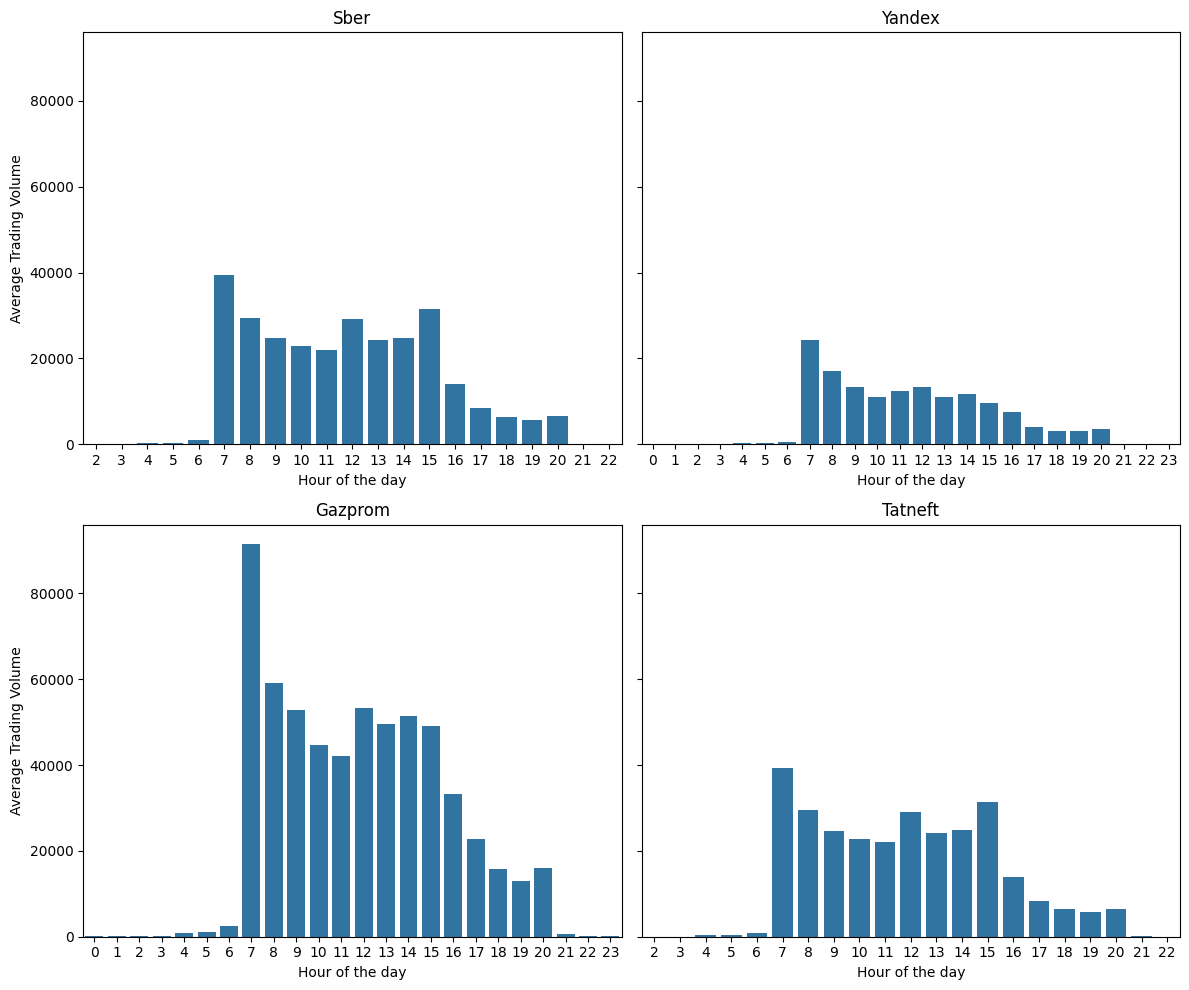

In [52]:
calculate_hourly_volume(dfs, labels = labels)